In [1]:
import pandas as pd
import os

In [2]:
#2014
    
ben_api = pd.read_csv("ben_api_2014.csv")
mal_api = pd.read_csv("mal_api_2014.csv")

In [3]:
ben_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39930 entries, 0 to 39929
Columns: 1849 entries, apkname to Lorg/w3c/dom/Element;.getElementsByTagNameNS:(Ljava/lang/String;Ljava/lang/String;)Lorg/w3c/dom/NodeList;
dtypes: int64(1848), object(1)
memory usage: 563.3+ MB


In [4]:
mal_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10073 entries, 0 to 10072
Columns: 1849 entries, apkname to Lorg/w3c/dom/Element;.getElementsByTagNameNS:(Ljava/lang/String;Ljava/lang/String;)Lorg/w3c/dom/NodeList;
dtypes: int64(1848), object(1)
memory usage: 142.1+ MB


In [5]:
#ben, mal 수 맞춰주기

ben_api_del = ben_api[:10073]

In [6]:
import numpy as np

ben = np.zeros((len(ben_api_del), 1), int)

mal = np.ones((len(mal_api), 1), int)

label = np.concatenate((ben, mal), axis=0)
label

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [7]:
len(label)

20146

In [8]:
api2014 = pd.concat([ben_api_del, mal_api])

In [9]:
api2014.drop('apkname', axis=1, inplace=True)

In [10]:
len(ben_api_del), len(mal_api)

(10073, 10073)

In [77]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(api2014, label, test_size=0.2, random_state=42)

In [78]:
x_train.shape

(16116, 1848)

In [79]:
y_train.shape

(16116, 1)

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

In [14]:
lin_reg.predict(x_test)

array([[0.77991978],
       [1.20274722],
       [0.03919895],
       ...,
       [0.41671476],
       [1.25006236],
       [0.90457706]])

In [15]:
from sklearn.metrics import mean_squared_error

predictions2014 = lin_reg.predict(x_train)
lin_mse = mean_squared_error(y_train, predictions2014)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.28032641540632475

In [16]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, predictions2014)
lin_mae

0.22402913657433393

In [17]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, x_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [92]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [0.35517846 0.42374419 0.31896243 0.42901583 0.41705934 0.35639016
 0.37779541 0.43674377 0.310966   0.38054229]
평균: 0.38063978786000285
표준 편차: 0.043098989380614725


In [160]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}'.format(accuracy, precision, recall))
    print('f1-score : {0:.4f}, auc : {1:.4f}'.format(f1, roc_score))

In [116]:
#트리 모델 별 성능 평가

#결정 트리 분류기
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time

start_time = time.time()

tree_clf = DecisionTreeClassifier(random_state=42)
history = tree_clf.fit(x_train, y_train)
end_time = time.time() - start_time

tree_trainpred = tree_clf.predict(x_train) 
tree_trainacc = accuracy_score(y_train, tree_trainpred)

tree_testpred = tree_clf.predict(x_test)
tree_testacc = accuracy_score(y_test, tree_testpred)

print(f"모델 정확도(train) : {tree_trainacc :.4f}")
print(f"모델 정확도(test) : {tree_testacc :.4f}")
print(f"학습 시간 : {end_time :.4f}")

모델 정확도(train) : 0.9958
모델 정확도(test) : 0.9772
학습 시간 : 0.8450


In [161]:
metrics(y_train, tree_trainpred)
metrics(y_test, tree_testpred)

정확도 : 0.9958, 정밀도 : 0.9927, 재현율 : 0.9989
f1-score : 0.9958, auc : 0.9958
정확도 : 0.9772, 정밀도 : 0.9703, 재현율 : 0.9847
f1-score : 0.9774, auc : 0.9771


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Decision Tree_train')

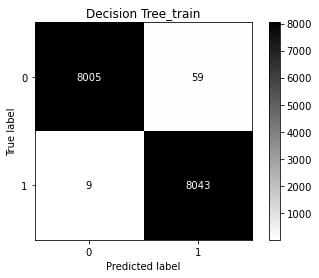

In [154]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

plot = plot_confusion_matrix(tree_clf,
                            x_train, y_train,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Decision Tree_train')

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Decision Tree_test')

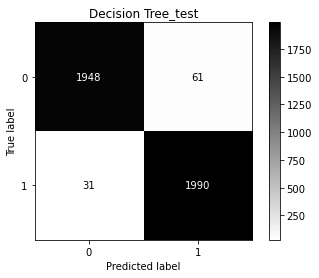

In [155]:
plot = plot_confusion_matrix(tree_clf,
                            x_test, y_test,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Decision Tree_test')

In [117]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])

AttributeError: 'DecisionTreeClassifier' object has no attribute 'history'

In [181]:
## GridSearchCV 이용해서 교차검증&최적의 파라미터 찾기
from sklearn.model_selection import GridSearchCV

params = {
    'min_samples_split':[11, 12, 13],
    'max_depth': [13, 14]
}

grid_cv = GridSearchCV(tree_clf, param_grid=params, cv=5, verbose=1)
grid_cv.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [13, 14],
                         'min_samples_split': [11, 12, 13]},
             verbose=1)

In [22]:
# from sklearn.model_selection import RandomizedSearchCV


# # 최적값을 구하고 싶은 파라미터를 정리 
# dists = {
#     'max_depth' : [3,5,10,15],
#     'max_features' : [3,5,10],
#     'n_estimators' : [80, 100, 150, 200]
# }

# # RandomizedSearchCV 작성
# rs_cv = RandomizedSearchCV(
#     tree_clf,
#     param_distributions=dists, # 파라미터 입력
#     n_iter = 500,   # random search 탐색 횟수
#     cv = 5,        # cv 검증을 위한 분할 검증 횟수
#     scoring='accuracy',  # 오차 평가방법
#     verbose=1,     # 진행상황
#     random_state = 42
#   )

# rs_cv.fit(x_train, y_train)

In [182]:
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

tree_b = grid_cv.best_estimator_
tree_b.fit(x_train, y_train)
tree_testbp = tree_b.predict(x_test)
tree_trainbp = tree_b.predict(x_train)
tree_testbs = accuracy_score(y_test, tree_testbp)
tree_trainbs = accuracy_score(y_train, tree_trainbp)
print("테스트 정확도:", tree_testbs)

최적의 파라미터: {'max_depth': 14, 'min_samples_split': 12}
최고의 정확도 : 0.9777241199843865
테스트 정확도: 0.9776674937965261


In [186]:
print(f"모델 정확도(train) : {tree_trainbs :.4f}")
print(f"모델 정확도(test) : {tree_testbs :.4f}")

모델 정확도(train) : 0.9874
모델 정확도(test) : 0.9777


정확도 : 0.9874, 정밀도 : 0.9883, 재현율 : 0.9865
f1-score : 0.9874, auc : 0.9874
정확도 : 0.9777, 정밀도 : 0.9768, 재현율 : 0.9787
f1-score : 0.9778, auc : 0.9777


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Decision Tree_test_GridsearchCV')

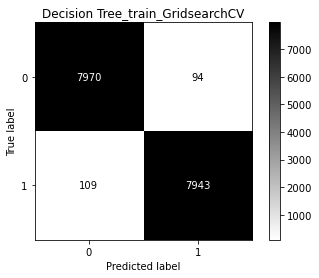

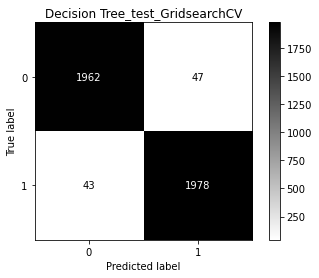

In [184]:
metrics(y_train, tree_trainbp)
metrics(y_test, tree_testbp)


plot = plot_confusion_matrix(tree_b,
                            x_train, y_train,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Decision Tree_train_GridsearchCV')

plot = plot_confusion_matrix(tree_b,
                            x_test, y_test,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Decision Tree_test_GridsearchCV')

In [24]:
#랜덤포레스트 분류기

from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(x_train, y_train)
end_time = time.time() - start_time

forest_trainpred = forest_clf.predict(x_train) 
forest_trainacc = accuracy_score(y_train, forest_trainpred)

forest_testpred = forest_clf.predict(x_test)
forest_testacc = accuracy_score(y_test, forest_testpred)

print(f"모델 정확도(train) : {forest_trainacc :.4f}")
print(f"모델 정확도(test) : {forest_testacc :.4f}")
print(f"학습 시간 : {end_time :.4f}")

/tmp/ipykernel_200/1296166286.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_clf.fit(x_train, y_train)


모델 정확도(train) : 0.9958
모델 정확도(test) : 0.9789
학습 시간 : 4.8436


정확도 : 0.9958, 정밀도 : 0.9926, 재현율 : 0.9990
f1-score : 0.9958, auc : 0.9958
정확도 : 0.9789, 정밀도 : 0.9717, 재현율 : 0.9866
f1-score : 0.9791, auc : 0.9789


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Landroid/accounts/AccountManager;.addAccount:(Ljava/lang/String;Ljava/lang/String;_Ljava/lang/String;Landroid/os/Bundle;Landroid/app/Activity;Landroid/accounts/AccountManagerCallback;Landroid/os/Handler;)Landroid/accounts/AccountManagerFuture;
- Landroid/accounts/AccountManager;.getAccounts:()_Landroid/accounts/Account;
- Landroid/accounts/AccountManager;.getAccountsByType:(L

Text(0.5, 1.0, 'Random Forest_test')

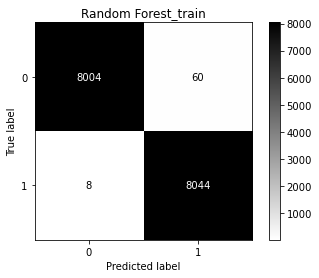

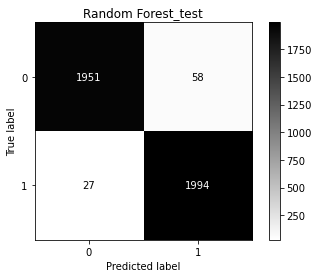

In [163]:
metrics(y_train, forest_trainpred)
metrics(y_test, forest_testpred)

plot = plot_confusion_matrix(forest_clf,
                            x_train, y_train,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Random Forest_train')

plot = plot_confusion_matrix(forest_clf,
                            x_test, y_test,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Random Forest_test')

In [25]:
import numpy as np

importances = forest_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature Rank:")

for f in range(api2014.shape[1]):
    print("{}. {} ({:.3f})".format(f + 1, api2014.columns[indices][f], importances[indices[f]]))

Feature Rank:
1. Landroid/content/ContentResolver;.query:(Landroid/net/Uri;[Ljava/lang/String;Ljava/lang/String;[Ljava/lang/String;Ljava/lang/String;)Landroid/database/Cursor; (0.103)
2. Ljava/util/Timer;.schedule:(Ljava/util/TimerTask;JJ)V (0.041)
3. Landroid/webkit/WebView;.loadDataWithBaseURL:(Ljava/lang/String;Ljava/lang/String;Ljava/lang/String;Ljava/lang/String;Ljava/lang/String;)V (0.036)
4. Landroid/location/LocationManager;.requestLocationUpdates:(Ljava/lang/String;JFLandroid/location/LocationListener;)V (0.024)
5. Landroid/content/pm/PackageManager;.getInstalledPackages:(I)Ljava/util/List; (0.016)
6. Landroid/location/LocationManager;.requestLocationUpdates:(Ljava/lang/String;JFLandroid/location/LocationListener;Landroid/os/Looper;)V (0.015)
7. Ljava/lang/StringBuilder;.append:(Ljava/lang/Object;)Ljava/lang/StringBuilder; (0.013)
8. Landroid/net/NetworkInfo;.getTypeName:()Ljava/lang/String; (0.012)
9. Landroid/telephony/TelephonyManager;.getDeviceId:()Ljava/lang/String; (0.01

791. Ljava/net/Socket;.<init>:(Ljava/net/InetAddress;IZ)V (0.000)
792. Landroid/webkit/WebView;.setFadingEdgeLength:(I)V (0.000)
793. Landroid/media/AudioRecord;.getAudioSessionId:()I (0.000)
794. Landroid/webkit/WebView;.isVerticalScrollBarEnabled:()Z (0.000)
795. Landroid/webkit/WebView;.offsetTopAndBottom:(I)V (0.000)
796. Landroid/content/ContentResolver;.getCurrentSyncs:()Ljava/util/List; (0.000)
797. Landroid/media/AudioManager;.isBluetoothA2dpOn:()Z (0.000)
798. Landroid/media/AudioRecord;.setRecordPositionUpdateListener:(Landroid/media/AudioRecord$OnRecordPositionUpdateListener;Landroid/os/Handler;)V (0.000)
799. Landroid/accounts/AbstractAccountAuthenticator;.getAccountRemovalAllowed:(Landroid/accounts/AccountAuthenticatorResponse;Landroid/accounts/Account;)Landroid/os/Bundle; (0.000)
800. Landroid/webkit/WebViewFragment;.<init>:()V (0.000)
801. Landroid/accounts/AccountManager;.setUserData:(Landroid/accounts/Account;Ljava/lang/String;Ljava/lang/String;)V (0.000)
802. Landroid

919. Landroid/media/AudioRecordingConfiguration;.wait:(J)V (0.000)
920. Landroid/media/AudioRecordingConfiguration;.wait:()V (0.000)
921. Landroid/media/AudioRecordingConfiguration;.toString:()Ljava/lang/String; (0.000)
922. Landroid/media/AudioRecordingConfiguration;.notifyAll:()V (0.000)
923. Landroid/media/AudioRecordingConfiguration;.notify:()V (0.000)
924. Landroid/media/AudioRecordingConfiguration;.hashCode:()I (0.000)
925. Landroid/media/AudioRecordingConfiguration;.getFormat:()Landroid/media/AudioFormat; (0.000)
926. Landroid/media/AudioRecordingConfiguration;.getClientFormat:()Landroid/media/AudioFormat; (0.000)
927. Landroid/media/AudioRecordingConfiguration;.getClientAudioSource:()I (0.000)
928. Landroid/media/AudioRecordingConfiguration;.getClientAudioSessionId:()I (0.000)
929. Landroid/media/AudioRecordingConfiguration;.getClass:()Ljava/lang/Class; (0.000)
930. Landroid/media/AudioRecordingConfiguration;.getAudioDevice:()Landroid/media/AudioDeviceInfo; (0.000)
931. Landroi

In [26]:
params = {
    'n_estimators': [36, 37, 38],
    'max_depth': [21, 22],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [2, 3, 4]
}

grid_cv = GridSearchCV(forest_clf, param_grid=params, cv=5, verbose=1)
grid_cv.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataCon

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [21, 22], 'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [36, 37, 38]},
             verbose=1)

In [27]:
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

forest_b = grid_cv.best_estimator_
forest_b.fit(x_train, y_train)

최적의 파라미터: {'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 38}
최고의 정확도 : 0.9728844864262678


/tmp/ipykernel_200/29744953.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_b.fit(x_train, y_train)


테스트 정확도: 0.9761786600496278


In [188]:
forest_testbp = forest_b.predict(x_test)
forest_testbs = accuracy_score(y_test, forest_testbp)
forest_trainbp = forest_b.predict(x_train)
forest_trainbs = accuracy_score(y_train,forest_trainbp)

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Landroid/accounts/AccountManager;.addAccount:(Ljava/lang/String;Ljava/lang/String;_Ljava/lang/String;Landroid/os/Bundle;Landroid/app/Activity;Landroid/accounts/AccountManagerCallback;Landroid/os/Handler;)Landroid/accounts/AccountManagerFuture;
- Landroid/accounts/AccountManager;.getAccounts:()_Landroid/accounts/Account;
- Landroid/accounts/AccountManager;.getAccountsByType:(Ljava/lang/String;)_Landroid/accounts/Account;
- Landroid/accounts/AccountManager;.getAccountsByTypeAndFeatures:(Ljava/lang/String;_Ljava/lang/String;Landroid/accounts/AccountManagerCallback;Landroid/os/Handler;)Landroid/accounts/AccountManagerFuture;
- Landroid/accounts/AccountManager;.getAccountsByTypeForPackage:(Ljava/lang/String;Ljava/lang/String;)_Landroid/accounts/Account;
- ..

정확도 : 0.9874, 정밀도 : 0.9883, 재현율 : 0.9865
f1-score : 0.9874, auc : 0.9874
정확도 : 0.9777, 정밀도 : 0.9768, 재현율 : 0.9787
f1-score : 0.9778, auc : 0.9777


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Decision Tree_test_GridsearchCV')

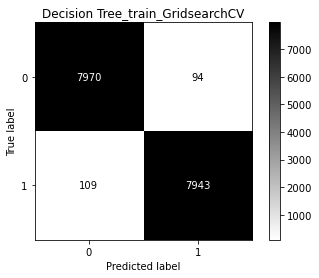

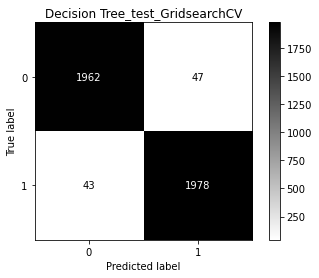

In [189]:
forest_testbp = forest_b.predict(x_test)
forest_testbs = accuracy_score(y_test, forest_testbp)
forest_trainbp = forest_b.predict(x_train)
forest_trainbs = accuracy_score(y_train,forest_trainbp)

metrics(y_train, tree_trainbp)
metrics(y_test, tree_testbp)


plot = plot_confusion_matrix(tree_b,
                            x_train, y_train,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Decision Tree_train_GridsearchCV')

plot = plot_confusion_matrix(tree_b,
                            x_test, y_test,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Decision Tree_test_GridsearchCV')

In [28]:
#그라디언트부스팅머신

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(x_train, y_train)
end_time = time.time() - start_time

gb_trainpred = gb_clf.predict(x_train) 
gb_trainacc = accuracy_score(y_train, gb_trainpred)

gb_testpred = gb_clf.predict(x_test)
gb_testacc = accuracy_score(y_test, gb_testpred)

print(f"모델 정확도(train) : {gb_trainacc :.4f}")
print(f"모델 정확도(test) : {gb_testacc :.4f}")
print(f"학습 시간 : {end_time :.4f}")

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


모델 정확도(train) : 0.9842
모델 정확도(test) : 0.9809
학습 시간 : 23.4739


정확도 : 0.9842, 정밀도 : 0.9842, 재현율 : 0.9842
f1-score : 0.9842, auc : 0.9842
정확도 : 0.9809, 정밀도 : 0.9755, 재현율 : 0.9866
f1-score : 0.9811, auc : 0.9809


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Landroid/accounts/AccountManager;.addAccount:(Ljava/lang/String;Ljava/lang/String;_Ljava/lang/String;Landroid/os/Bundle;Landroid/app/Activity;Landroid/accounts/AccountManagerCallback;Landroid/os/Handler;)Landroid/accounts/AccountManagerFuture;
- Landroid/accounts/AccountManager;.getAccounts:()_Landroid/accounts/Account;
- Landroid/accounts/AccountManager;.getAccountsByType:(L

Text(0.5, 1.0, 'Gradient Boost_test')

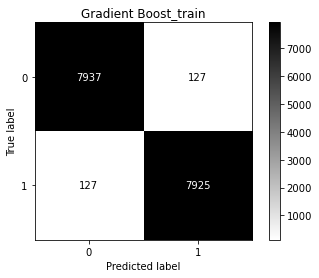

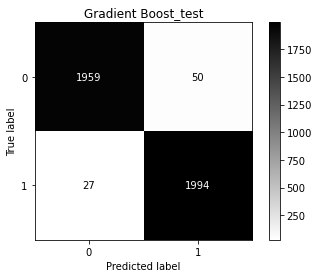

In [164]:
metrics(y_train, gb_trainpred)
metrics(y_test, gb_testpred)

plot = plot_confusion_matrix(gb_clf,
                            x_train, y_train,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Gradient Boost_train')

plot = plot_confusion_matrix(gb_clf,
                            x_test, y_test,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Gradient Boost_test')

In [ ]:
params = {
    'n_estimators': [70, 72, 74],
    'learning_rate': [0.3, 0.35, 0.4]
}

grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=5, verbose=1)
grid_cv.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

In [103]:
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

gb_b = grid_cv.best_estimator_
gb_b.fit(x_train, y_train)
# gb_bp = gb_b.predict(x_test)
# gb_bs = accuracy_score(y_test, gb_bp)
# print("테스트 정확도:", gb_bs)

최적의 파라미터: {'learning_rate': 0.3, 'n_estimators': 74}
최고의 정확도 : 0.9842395768934356


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


테스트 정확도: 0.9826302729528535


In [191]:
gb_testbp = gb_b.predict(x_test)
gb_testbs = accuracy_score(y_test, gb_testbp)
gb_trainbp = gb_b.predict(x_train)
gb_trainbs = accuracy_score(y_train,gb_trainbp)

metrics(y_train, gb_trainbp)
metrics(y_test, gb_testbp)

AttributeError: 'NoneType' object has no attribute 'tree_'

In [80]:
y_train_xgb = pd.DataFrame(y_train, columns=['ans'])
y_test_xgb = pd.DataFrame(y_test, columns=['ans'])

In [81]:
y_train_xgb

,ans
0,0
1,0
2,0
3,0
4,1
...,...
16111,1
16112,1
16113,0
16114,0


In [86]:
x_train_xgb = x_train
x_test_xgb = x_test

In [87]:
x_test_xgb

,Landroid/accounts/AbstractAccountAuthenticator;.getAccountRemovalAllowed:(Landroid/accounts/AccountAuthenticatorResponse;Landroid/accounts/Account;)Landroid/os/Bundle;,Landroid/accounts/AccountManager;.addAccount:(Ljava/lang/String;Ljava/lang/String;[Ljava/lang/String;Landroid/os/Bundle;Landroid/app/Activity;Landroid/accounts/AccountManagerCallback;Landroid/os/Handler;)Landroid/accounts/AccountManagerFuture;,Landroid/accounts/AccountManager;.addAccountExplicitly:(Landroid/accounts/Account;Ljava/lang/String;Landroid/os/Bundle;)Z,Landroid/accounts/AccountManager;.addOnAccountsUpdatedListener:(Landroid/accounts/OnAccountsUpdateListener;Landroid/os/Handler;Z)V,Landroid/accounts/AccountManager;.blockingGetAuthToken:(Landroid/accounts/Account;Ljava/lang/String;Z)Ljava/lang/String;,Landroid/accounts/AccountManager;.clearPassword:(Landroid/accounts/Account;)V,Landroid/accounts/AccountManager;.confirmCredentials:(Landroid/accounts/Account;Landroid/os/Bundle;Landroid/app/Activity;Landroid/accounts/AccountManagerCallback;Landroid/os/Handler;)Landroid/accounts/AccountManagerFuture;,Landroid/accounts/AccountManager;.getAccounts:()[Landroid/accounts/Account;,Landroid/accounts/AccountManager;.getAccountsByType:(Ljava/lang/String;)[Landroid/accounts/Account;,Landroid/accounts/AccountManager;.getAccountsByTypeAndFeatures:(Ljava/lang/String;[Ljava/lang/String;Landroid/accounts/AccountManagerCallback;Landroid/os/Handler;)Landroid/accounts/AccountManagerFuture;,...,Ljavax/net/ssl/HttpsURLConnection;.getOutputStream:()Ljava/io/OutputStream;,Ljavax/net/ssl/HttpsURLConnection;.setRequestMethod:(Ljava/lang/String;)V,Ljavax/net/ssl/SSLSocket;.getInputStream:()Ljava/io/InputStream;,Ljavax/net/ssl/SSLSocket;.getOutputStream:()Ljava/io/OutputStream;,Lorg/w3c/dom/Document;.getDocumentElement:()Lorg/w3c/dom/Element;,Lorg/w3c/dom/Document;.getElementsByTagName:(Ljava/lang/String;)Lorg/w3c/dom/NodeList;,Lorg/w3c/dom/Document;.getElementsByTagNameNS:(Ljava/lang/String;Ljava/lang/String;)Lorg/w3c/dom/NodeList;,Lorg/w3c/dom/Element;.getAttribute:(Ljava/lang/String;)Ljava/lang/String;,Lorg/w3c/dom/Element;.getElementsByTagName:(Ljava/lang/String;)Lorg/w3c/dom/NodeList;,Lorg/w3c/dom/Element;.getElementsByTagNameNS:(Ljava/lang/String;Ljava/lang/String;)Lorg/w3c/dom/NodeList;
5614,0,0,0,0,0,0,0,2,1,0,...,0,0,0,0,0,0,0,0,0,0
315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5485,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
5848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,0,0,2,3,0
7319,0,0,0,0,0,0,0,5,19,0,...,0,0,0,0,3,6,0,107,82,0
7861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

x_train_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))
   else col for col in x_train_xgb.columns.values
]

y_train_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))
   else col for col in y_train_xgb.columns.values
]

x_test_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))
   else col for col in x_test_xgb.columns.values
]

y_test_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<')))
   else col for col in y_test_xgb.columns.values
]

In [96]:
#XGBoost

from xgboost import XGBClassifier

evals = [(x_test_xgb, y_test_xgb)]

start_time = time.time()

xgb = XGBClassifier(random_state=42)
xgb.fit(x_train_xgb, y_train_xgb, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=1)

end_time = time.time() - start_time

xgb_trainpred = xgb.predict(x_train_xgb) 
xgb_trainacc = accuracy_score(y_train_xgb, xgb_trainpred)

xgb_testpred = xgb.predict(x_test_xgb)
xgb_testacc = accuracy_score(y_test_xgb, xgb_testpred)

print(f"모델 정확도(train) : {xgb_trainacc :.4f}")
print(f"모델 정확도(test) : {xgb_testacc :.4f}")
print(f"학습 시간 : {end_time :.4f}")

/home/sermadl/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/sermadl/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.46853
[1]	validation_0-logloss:0.34234
[2]	validation_0-logloss:0.25849
[3]	validation_0-logloss:0.20266
[4]	validation_0-logloss:0.16355
[5]	validation_0-logloss:0.13633
[6]	validation_0-logloss:0.11484
[7]	validation_0-logloss:0.10023
[8]	validation_0-logloss:0.08928
[9]	validation_0-logloss:0.08110
[10]	validation_0-logloss:0.07377
[11]	validation_0-logloss:0.06764
[12]	validation_0-logloss:0.06158
[13]	validation_0-logloss:0.05865
[14]	validation_0-logloss:0.05560
[15]	validation_0-logloss:0.05334
[16]	validation_0-logloss:0.05135
[17]	validation_0-logloss:0.04906
[18]	validation_0-logloss:0.04793
[19]	validation_0-logloss:0.04718
[20]	validation_0-logloss:0.04530
[21]	validation_0-logloss:0.04430
[22]	validation_0-logloss:0.04362
[23]	validation_0-logloss:0.04304
[24]	validation_0-logloss:0.04252
[25]	validation_0-logloss:0.04167
[26]	validation_0-logloss:0.04133
[27]	validation_0-logloss:0.04087
[28]	validation_0-logloss:0.04042
[29]	validation_0-loglos

정확도 : 0.9952, 정밀도 : 0.9922, 재현율 : 0.9981
f1-score : 0.9952, auc : 0.9952
정확도 : 0.9856, 정밀도 : 0.9790, 재현율 : 0.9926
f1-score : 0.9857, auc : 0.9856


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'XG Boost_test')

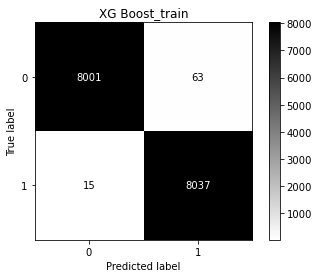

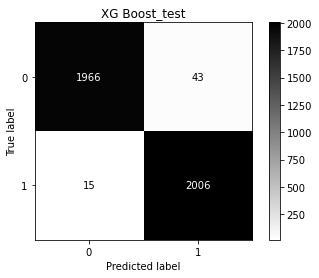

In [176]:
metrics(y_train_xgb, xgb_trainpred)
metrics(y_test_xgb, xgb_testpred)

plot = plot_confusion_matrix(xgb,
                            x_train_xgb, y_train_xgb,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('XG Boost_train')

plot = plot_confusion_matrix(xgb,
                            x_test_xgb, y_test_xgb,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('XG Boost_test')

In [109]:
params = {
    'n_estimators':[50, 55],
    'learning_rate': [0.2, 0.25, 0.3],
    'max_depth': [8, 10]
}

grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, verbose=1)
grid_cv.fit(x_train_xgb, y_train_xgb)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                   

In [110]:
print("최적의 파라미터:", grid_cv.best_params_)
print("최고의 정확도 :", grid_cv.best_score_)

xgb_b = grid_cv.best_estimator_
xgb_b.fit(x_train_xgb, y_train_xgb)
xgb_bp = xgb_b.predict(x_test_xgb)
xgb_bs = accuracy_score(y_test_xgb, xgb_bp)
print("테스트 정확도:", xgb_bs)

최적의 파라미터: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 55}
최고의 정확도 : 0.9870938678188486
테스트 정확도: 0.986848635235732


In [172]:
x_train_lgbm = x_train_xgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_train_lgbm = y_train_xgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_test_lgbm = x_test_xgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
y_test_lgbm = y_test_xgb.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [174]:
x_train_lgbm

,LandroidaccountsAbstractAccountAuthenticatorgetAccountRemovalAllowedLandroidaccountsAccountAuthenticatorResponseLandroidaccountsAccountLandroidosBundle,LandroidaccountsAccountManageraddAccountLjavalangStringLjavalangString_LjavalangStringLandroidosBundleLandroidappActivityLandroidaccountsAccountManagerCallbackLandroidosHandlerLandroidaccountsAccountManagerFuture,LandroidaccountsAccountManageraddAccountExplicitlyLandroidaccountsAccountLjavalangStringLandroidosBundleZ,LandroidaccountsAccountManageraddOnAccountsUpdatedListenerLandroidaccountsOnAccountsUpdateListenerLandroidosHandlerZV,LandroidaccountsAccountManagerblockingGetAuthTokenLandroidaccountsAccountLjavalangStringZLjavalangString,LandroidaccountsAccountManagerclearPasswordLandroidaccountsAccountV,LandroidaccountsAccountManagerconfirmCredentialsLandroidaccountsAccountLandroidosBundleLandroidappActivityLandroidaccountsAccountManagerCallbackLandroidosHandlerLandroidaccountsAccountManagerFuture,LandroidaccountsAccountManagergetAccounts_LandroidaccountsAccount,LandroidaccountsAccountManagergetAccountsByTypeLjavalangString_LandroidaccountsAccount,LandroidaccountsAccountManagergetAccountsByTypeAndFeaturesLjavalangString_LjavalangStringLandroidaccountsAccountManagerCallbackLandroidosHandlerLandroidaccountsAccountManagerFuture,...,LjavaxnetsslHttpsURLConnectiongetOutputStreamLjavaioOutputStream,LjavaxnetsslHttpsURLConnectionsetRequestMethodLjavalangStringV,LjavaxnetsslSSLSocketgetInputStreamLjavaioInputStream,LjavaxnetsslSSLSocketgetOutputStreamLjavaioOutputStream,Lorgw3cdomDocumentgetDocumentElementLorgw3cdomElement,Lorgw3cdomDocumentgetElementsByTagNameLjavalangStringLorgw3cdomNodeList,Lorgw3cdomDocumentgetElementsByTagNameNSLjavalangStringLjavalangStringLorgw3cdomNodeList,Lorgw3cdomElementgetAttributeLjavalangStringLjavalangString,Lorgw3cdomElementgetElementsByTagNameLjavalangStringLorgw3cdomNodeList,Lorgw3cdomElementgetElementsByTagNameNSLjavalangStringLjavalangStringLorgw3cdomNodeList
2394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
7615,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4317,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [175]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)

evals = [(x_train_lgbm, y_train_lgbm)]

start_time = time.time()

lgbm.fit(x_train_lgbm, y_train_lgbm, early_stopping_rounds=100, eval_set=evals, eval_metric='logloss', verbose=1)

end_time = time.time() - start_time

lgbm_trainpred = lgbm.predict(x_train_lgbm)
lgbm_trainacc = accuracy_score(y_train_lgbm, lgbm_trainpred)

lgbm_testpred = lgbm.predict(x_test_lgbm)
lgbm_testacc = accuracy_score(y_test_lgbm, lgbm_testpred)

print(f"모델 정확도(train) : {lgbm_trainacc :.4f}")
print(f"모델 정확도(test) : {lgbm_testacc :.4f}")
print(f"학습 시간 : {end_time :.4f}")

/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/sermadl/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/sermadl/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.p

[1]	training's binary_logloss: 0.60521
[2]	training's binary_logloss: 0.533397
[3]	training's binary_logloss: 0.47315
[4]	training's binary_logloss: 0.422252
[5]	training's binary_logloss: 0.37849
[6]	training's binary_logloss: 0.340716
[7]	training's binary_logloss: 0.307921
[8]	training's binary_logloss: 0.278478
[9]	training's binary_logloss: 0.253096
[10]	training's binary_logloss: 0.230519
[11]	training's binary_logloss: 0.210489
[12]	training's binary_logloss: 0.192963
[13]	training's binary_logloss: 0.176848
[14]	training's binary_logloss: 0.162492
[15]	training's binary_logloss: 0.149731
[16]	training's binary_logloss: 0.138146
[17]	training's binary_logloss: 0.127653
[18]	training's binary_logloss: 0.118385
[19]	training's binary_logloss: 0.109991
[20]	training's binary_logloss: 0.102352
[21]	training's binary_logloss: 0.0954394
[22]	training's binary_logloss: 0.0889841
[23]	training's binary_logloss: 0.0832438
[24]	training's binary_logloss: 0.077996
[25]	training's binary_lo

정확도 : 0.9953, 정밀도 : 0.9922, 재현율 : 0.9985
f1-score : 0.9954, auc : 0.9953
정확도 : 0.9873, 정밀도 : 0.9828, 재현율 : 0.9921
f1-score : 0.9874, auc : 0.9873


/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/sermadl/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Light GBM_test')

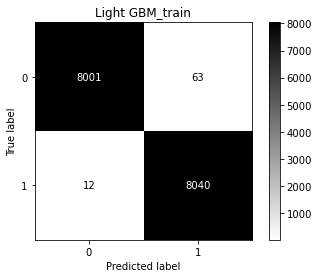

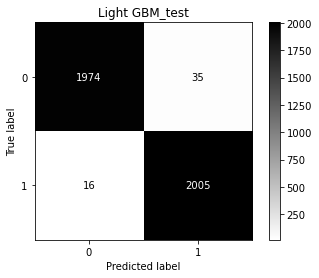

In [178]:
metrics(y_train_lgbm, lgbm_trainpred)
metrics(y_test_lgbm, lgbm_testpred)

plot = plot_confusion_matrix(lgbm,
                            x_train, y_train,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Light GBM_train')

plot = plot_confusion_matrix(lgbm,
                            x_test, y_test,
                            display_labels=[0, 1],
                            cmap=plt.cm.binary)

plot.ax_.set_title('Light GBM_test')